# README
## Algorithm Feedback Loop Simulation
### The following code simulates a series of environmnets for social media content consumption. It shows how user's utility evolves over time under different algorithm designs. It also tracks creator payouts over time. The goal of this exercise is to explore how outcomes change under different algorithms and with heterogenous goods.
## Notes:
### Due to time constraints, this code is not optimized that much. For example, it uses matrix notation at some points. But I think a dataframe would actually be better. 
### The only optimizaiton I did was to iterate probabilities outside of the simulation loops. 
### However, for large N and large K, the simulation is slower. With N=100,000, the homogenous simulation takes about 35 seconds (heterogenous is slightly faster)
### There are lots of ways this model could be improved. I encourage the reader to add fidelity. Let me know what you discover. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Functions: transition probability, simulate, and plot simulation
def transitionFunctionSigmoid(V,shift):
    return 1 / (1 + np.exp(-10*(V+shift)))

def simulation(algo_type, memory=2):
    """
    Run a simulation of content consumption with different recommendation algorithms.
    
    Parameters:
    - algo_type: str, options: 'none', 'max_utility', 'popularity'
    - T: int, number of time periods
    - N: int, number of users
    - delta: float, probability of inactive users returning
    - memory: int, number of previous periods to consider for popularity algorithm
    """
    # Pre-allocate arrays for storing results
    user_history = np.zeros(T)
    utility_history = np.zeros(T)
    consumption_history = np.zeros((T, K))
    gini_history = np.zeros(T)
    active = np.ones(N, dtype=bool)
    goods = np.arange(K)
    
    # Precompute reactivation probabilities
    reactivation_probs = np.random.rand(T, N)
    
    # Initialize D_normalized for each algorithm type
    if algo_type == 'Random':
        print("Running with no algorithm (random recommendations)")
        D_normalized = D / D.sum(axis=1, keepdims=True)
        
    elif algo_type == 'Individual':
        print("Running with max utility algorithm (individualized recommendations)")
        D_normalized = np.zeros_like(D)
        D_normalized[np.arange(N), np.argmax(U, axis=1)] = 1
        
    elif algo_type == 'Popular':
        print(f"Running with popularity algorithm (memory={memory} periods)")
        # Start with original preferences, will update each period
        D_normalized = D / D.sum(axis=1, keepdims=True)
    
    else:
        raise ValueError("algo_type must be 'none', 'max_utility', or 'popularity'")
    
    for t in range(T):
        # Reactivate each inactive player with probability delta
        inactive_indices = np.where(~active)[0]
        if len(inactive_indices) > 0:
            reactivated = reactivation_probs[t, inactive_indices] < DELTA
            active[inactive_indices[reactivated]] = True

        # Get current active users
        current_indices = np.where(active)[0]
        current_count = len(current_indices)
        
        if current_count == 0:
            # End simulation early if no active users remain
            print(f"No users remaining after {t} periods")
            user_history = user_history[:t]
            utility_history = utility_history[:t]
            consumption_history = consumption_history[:t]
            break
            
        # Record active users
        user_history[t] = current_count
        
        # Update popularity-based recommendations if using that algorithm
        if algo_type == 'Popular' and t > 0:
            # Look back at most recent 'memory' periods (or fewer if early in simulation)
            lookback = min(t, memory)
            
            # Sum consumption counts over the lookback period
            recent_consumption = np.sum(consumption_history[t-lookback:t], axis=0)
            
            # If we have consumption data, create popularity-based probabilities
            if np.sum(recent_consumption) > 0:
                # Normalize to create probability distribution
                popularity_probs = (recent_consumption / np.sum(recent_consumption)) # ** 2
                
                # Set all users to have the same probability distribution based on popularity
                D_normalized = np.tile(popularity_probs, (N, 1))
        
        # Select consumption choices for active users
        rand_vals = np.random.random(current_count)
        cumulative_probs = np.cumsum(D_normalized, axis=1)
        random_matrix = rand_vals[:, np.newaxis] * np.ones((1, K))
        comparison = random_matrix <= cumulative_probs[current_indices]
        C = np.argmax(comparison, axis=1)    
            
        # Count consumption per good and record
        count_per_good = np.bincount(C, minlength=K)
        consumption_history[t] = count_per_good

        # Calculate Gini coefficient for count_per_good
        gini = np.sum(np.abs(np.subtract.outer(count_per_good, count_per_good))) / (2 * len(count_per_good) * np.sum(count_per_good))
        gini_history[t] = gini

        # Calculate period utility: sum of utility for chosen goods
        period_utility = np.sum(U[current_indices, C])
        utility_history[t] = period_utility
        
        # Calculate transition probabilities for active users
        V_sim = U[current_indices, C]
        P = transitionFunctionSigmoid(V_sim,SHIFT)
        
        # Determine which active users continue to next period
        continue_probs = np.random.random(current_count)
        continue_mask = continue_probs <= P
        active[current_indices] = continue_mask

    # If the simulation completed all periods, no need to trim arrays
    if t == T-1:
        pass
    else:
        # Trim arrays to actual simulation length (t periods)
        user_history = user_history[:t]
        utility_history = utility_history[:t]
        consumption_history = consumption_history[:t]
        
    # Calculate cumulative histories
    cumulative_utility_history = np.cumsum(utility_history)
    cumulative_consumption_history = np.cumsum(consumption_history, axis=0)

    results = {
        'end_users': np.mean(user_history[-min(7, len(user_history)):]),
        'cum_utility': cumulative_utility_history[-1] if len(cumulative_utility_history) > 0 else 0,
        'avg_utility': np.median(utility_history / np.maximum(user_history, 1)),  # Avoid division by zero
        'cum_cons': cumulative_consumption_history[-1] if len(cumulative_consumption_history) > 0 else np.zeros(K),
        'user_history': user_history,
        'utility_history': utility_history,
        'cumulative_utility_history': cumulative_utility_history,
        'consumption_history': consumption_history,
        'cumulative_consumption_history': cumulative_consumption_history,
        'gini_history': gini_history,
    }
    
    print(f"System end state:")
    print(f"  Num Users: {results['end_users']}")
    print(f"  Total Welfare: {results['cum_utility']:,.2f}")
    print(f"  Median Utility: {results['avg_utility']}")
    print(f"  End Gini: {gini_history[-1]}")

    return results

def plotSimulation(results):
    user_history = results['user_history']
    cumulative_utility_history = results['cumulative_utility_history']
    cumulative_consumption_history=results['cumulative_consumption_history']
    gini_history = results['gini_history']
    periods = np.arange(len(user_history))
        # Plot the outcomes
    fig, axs = plt.subplots(4, 1, figsize=(10, 7), constrained_layout=True)

    # Plot 1: Total active users over time
    axs[0].plot(periods, user_history)
    axs[0].set_title('Active Users Over Time')
    axs[0].set_ylabel('Number of Active Users')
    axs[0].grid(True)

    # Plot 2: Cumulative utility over time
    axs[1].plot(periods, cumulative_utility_history)
    axs[1].set_title('Cumulative Utility Over Time')
    axs[1].set_ylabel('Cumulative Utility')
    axs[1].grid(True)

    # Plot 3: Consumption of each good over time
    for good in range(K):
        axs[2].plot(periods, cumulative_consumption_history[:, good], label=f'Good {good+1}')
    axs[2].set_title('Consumption of Each Good Over Time')
    axs[2].set_xlabel('Period')
    axs[2].set_ylabel('Consumption Count')
    axs[2].legend()
    axs[2].grid(True)

    # Plot 3: Consumption of each good over time
    axs[3].plot(periods, gini_history)
    axs[3].set_title('Gini of Good Income Over Time')
    axs[3].set_xlabel('Period')
    axs[3].set_ylabel('Gini')
    axs[3].grid(True)

    plt.show()
    
def plotSetUp():
    shift_values = [0, -0.1, -0.5, -0.75]
    x = np.linspace(0, 1, 100)
    x_min, x_max = 0, 1
    fig, axs = plt.subplots(1, 3, figsize=(15, 3), constrained_layout=True)

    # Plot 1: Transition Probability Functions (Sigmoid)
    for shift in shift_values:
        y = transitionFunctionSigmoid(x, shift)
        axs[0].plot(x, y, label=f"Sensitivity={shift}")
    axs[0].set_xlabel(r'$u_{ij}$')
    axs[0].set_ylabel(r'$p_{ij}$')
    axs[0].set_title('Transition Probability (Sigmoid)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot 2: Distribution of Utility across goods
    for j in range(K):
        sns.kdeplot(U[:, j], ax=axs[1], label=f"Good {j+1}")
    axs[1].set_xlabel("Utility")
    axs[1].set_ylabel("Density of Users")
    axs[1].set_title(f"Utility Distribution (K={K})")
    axs[1].set_xlim(x_min, x_max)
    axs[1].legend()
    axs[1].grid(True)

    # Plot 3: Distribution of Encounter Probabilities for each good
    for j in range(K):
        sns.kdeplot(D[:, j], ax=axs[2], label=f"Good {j+1}")
    axs[2].set_xlabel("Encounter Probability (Demand)")
    axs[2].set_ylabel("Density of Users")
    axs[2].set_title(f"Distribution of Encounters (K={K})")
    axs[2].set_xlim(x_min, x_max)
    axs[2].grid(True)

    plt.show()

def create_heterogeneous_utilities(N, K): # Function by AI, prompting by me.
    U = np.zeros((N, K))
    distributions = []
    if K % 2 == 1:
        middle_index = K // 2
        for j in range(K):
            dist_from_middle = j - middle_index
            if dist_from_middle == 0:
                alpha, beta = 5, 5
            else:
                skew_factor = abs(dist_from_middle)
                if dist_from_middle > 0:
                    alpha = 5 + skew_factor
                    beta = 5 - min(skew_factor, 3)  # Prevent beta from going below 2
                else:
                    alpha = 5 - min(skew_factor, 3)  # Prevent alpha from going below 2
                    beta = 5 + skew_factor
            distributions.append((alpha, beta))
            U[:, j] = np.random.beta(alpha, beta, size=N)
    else:
        for j in range(K):
            if j < K/2:
                skew_factor = (K/2 - j - 1)
                alpha = 5 - min(skew_factor, 3)
                beta = 5 + skew_factor
            else:
                skew_factor = (j - K/2)
                alpha = 5 + skew_factor
                beta = 5 - min(skew_factor, 3)
            distributions.append((alpha, beta)) 
            U[:, j] = np.random.beta(alpha, beta, size=N)    
    return U, distributions

### Assumptions:
1. Utility, u ~ Beta()
2. Encounter Probability, d ~ U(0,1)
3. Expected Utility = u*d
4. Transition Probability = p(v) = sigmoid(v)
5. N = 1000
6. $\delta=0.05$
7. T = 365
8. $algo \in$ [none, max individual, max welfare]

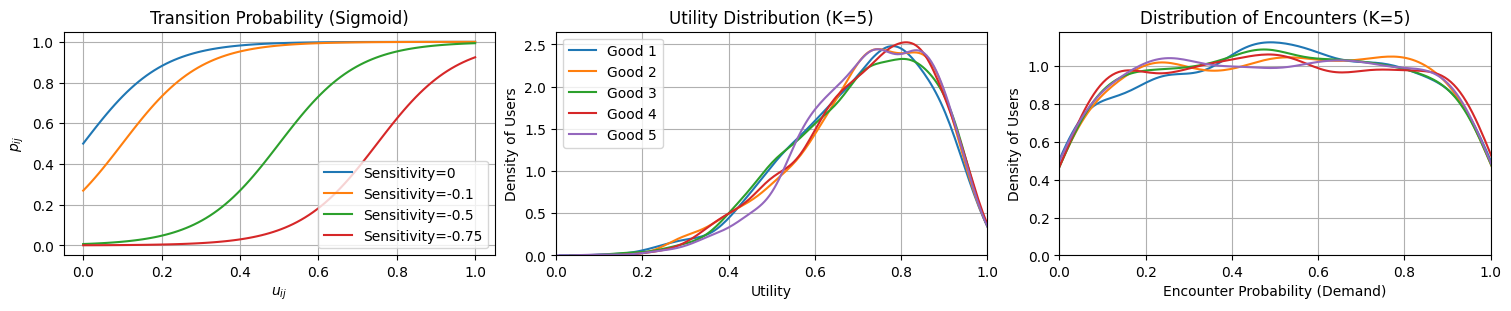

Running with no algorithm (random recommendations)
System end state:
  Num Users: 862.0
  Total Welfare: 287,466.16
  Median Utility: 0.723352556242252
  End Gini: 0.029336437718277066
Running with max utility algorithm (individualized recommendations)
System end state:
  Num Users: 983.8571428571429
  Total Welfare: 393,133.94
  Median Utility: 0.8821861314817775
  End Gini: 0.03699186991869919
Running with popularity algorithm (memory=2 periods)
System end state:
  Num Users: 897.8571428571429
  Total Welfare: 291,101.58
  Median Utility: 0.7257011336969426
  End Gini: 0.40489977728285076


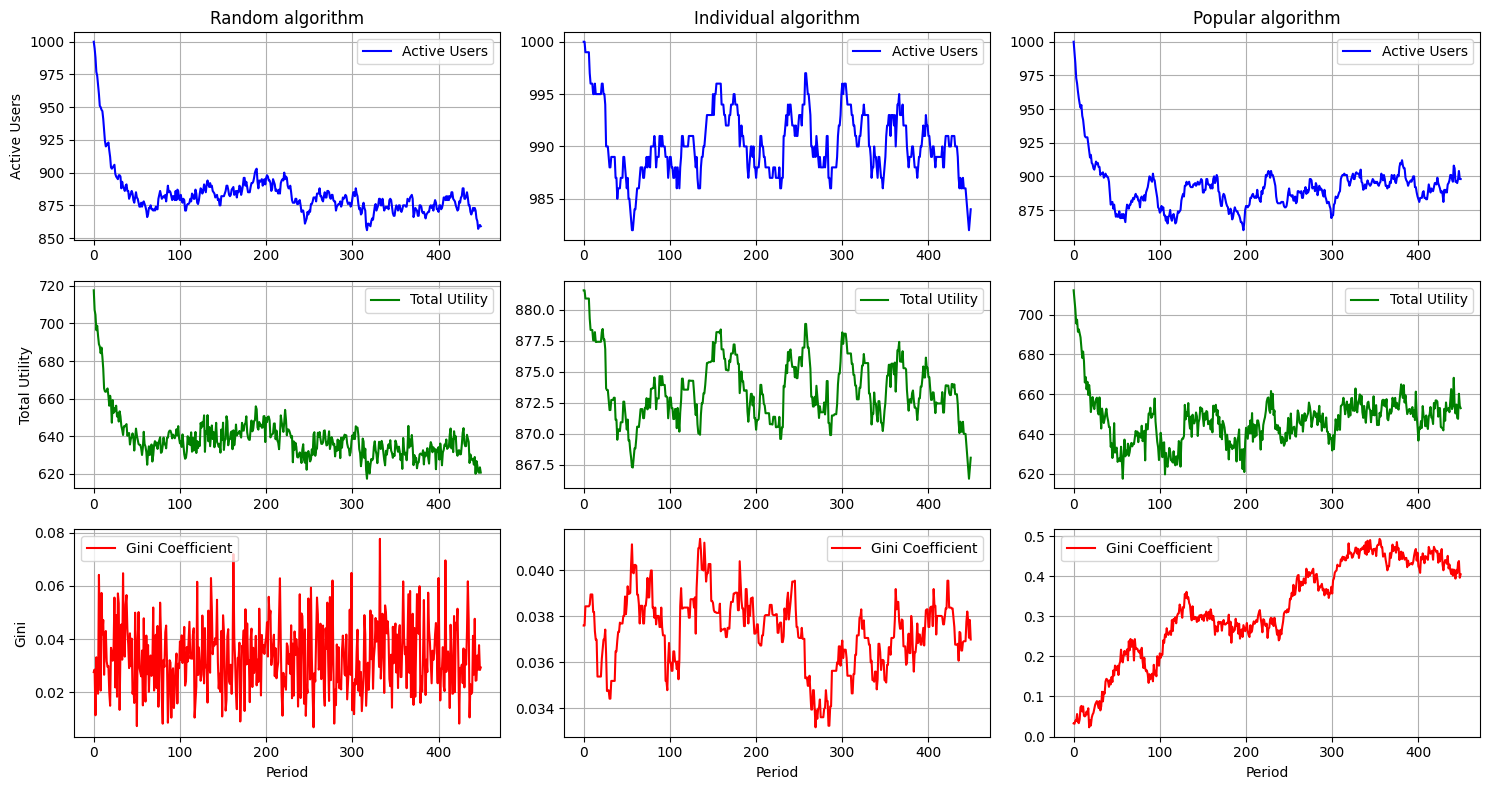

In [2]:
# Algorithm Run - Baseline
N = 1_000
K = 5
T = 450
DELTA = 0.05
SHIFT = -0.1

U = np.random.beta(5, 2, size=(N, K))   # Distribution of utility across K goods and N users
D = np.random.uniform(size=(N,K))       # Distribution of encounter probability
V = U * D                               # Get the expected probability matrix - element-wise multiplication
plotSetUp()

# Run simulations for each algorithm type and store the results
algo_types = ['Random', 'Individual', 'Popular']
sim_results = [simulation(algo) for algo in algo_types]

# Create a figure with 3 rows (metrics) and 3 columns (algorithms)
fig, axs = plt.subplots(3, 3, figsize=(15, 8))

# For each algorithm, plot the three metrics
for col, (algo, sim) in enumerate(zip(algo_types, sim_results)):
    periods = np.arange(len(sim['user_history']))
    
    # Row 0: Active Users Over Time
    axs[0, col].plot(periods, sim['user_history'], color='blue', label='Active Users')
    axs[0, col].set_title(f"{algo} algorithm")
    # Set y-axis label only for column 0
    if col == 0:
        axs[0, col].set_ylabel("Active Users")
    else:
        axs[0, col].set_ylabel("")
    # Omit x-axis labels for rows not in the last row
    axs[0, col].set_xlabel("")
    axs[0, col].grid(True)
    axs[0, col].legend()
    
    # Row 1: Cumulative Utility (Welfare) Over Time
    axs[1, col].plot(periods, sim['utility_history'], color='green', label='Total Utility')
    if col == 0:
        axs[1, col].set_ylabel("Total Utility")
    else:
        axs[1, col].set_ylabel("")
    axs[1, col].set_xlabel("")
    axs[1, col].grid(True)
    axs[1, col].legend()
    
    # Row 2: Gini Coefficient Over Time
    axs[2, col].plot(periods, sim['gini_history'], color='red', label='Gini Coefficient')
    if col == 0:
        axs[2, col].set_ylabel("Gini")
    else:
        axs[2, col].set_ylabel("")
    # Set x-axis label only for row 2 (last row)
    axs[2, col].set_xlabel("Period")
    axs[2, col].grid(True)
    axs[2, col].legend()

plt.tight_layout()
plt.show()


Distribution parameters for each good:
Good 0: Beta(3.0, 7.0), Mean = 0.300
Good 1: Beta(4.0, 6.0), Mean = 0.400
Good 2: Beta(5.0, 5.0), Mean = 0.500
Good 3: Beta(6.0, 4.0), Mean = 0.600
Good 4: Beta(7.0, 3.0), Mean = 0.700


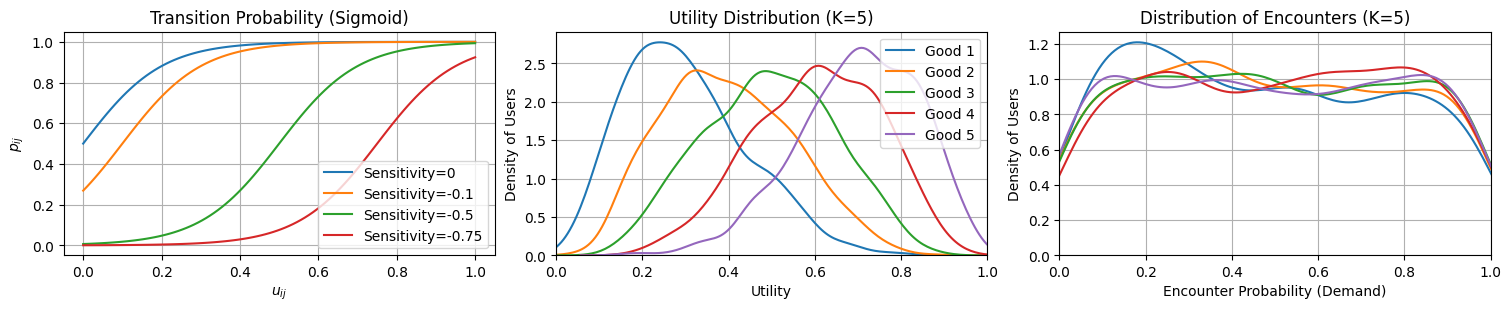

Running with no algorithm (random recommendations)
System end state:
  Num Users: 487.2857142857143
  Total Welfare: 119,273.65
  Median Utility: 0.5230684590235372
  End Gini: 0.07309236947791165
Running with max utility algorithm (individualized recommendations)
System end state:
  Num Users: 962.8571428571429
  Total Welfare: 329,215.28
  Median Utility: 0.7602641119721685
  End Gini: 0.569937369519833
Running with popularity algorithm (memory=2 periods)
System end state:
  Num Users: 509.2857142857143
  Total Welfare: 93,865.32
  Median Utility: 0.48095308646394463
  End Gini: 0.6784615384615384


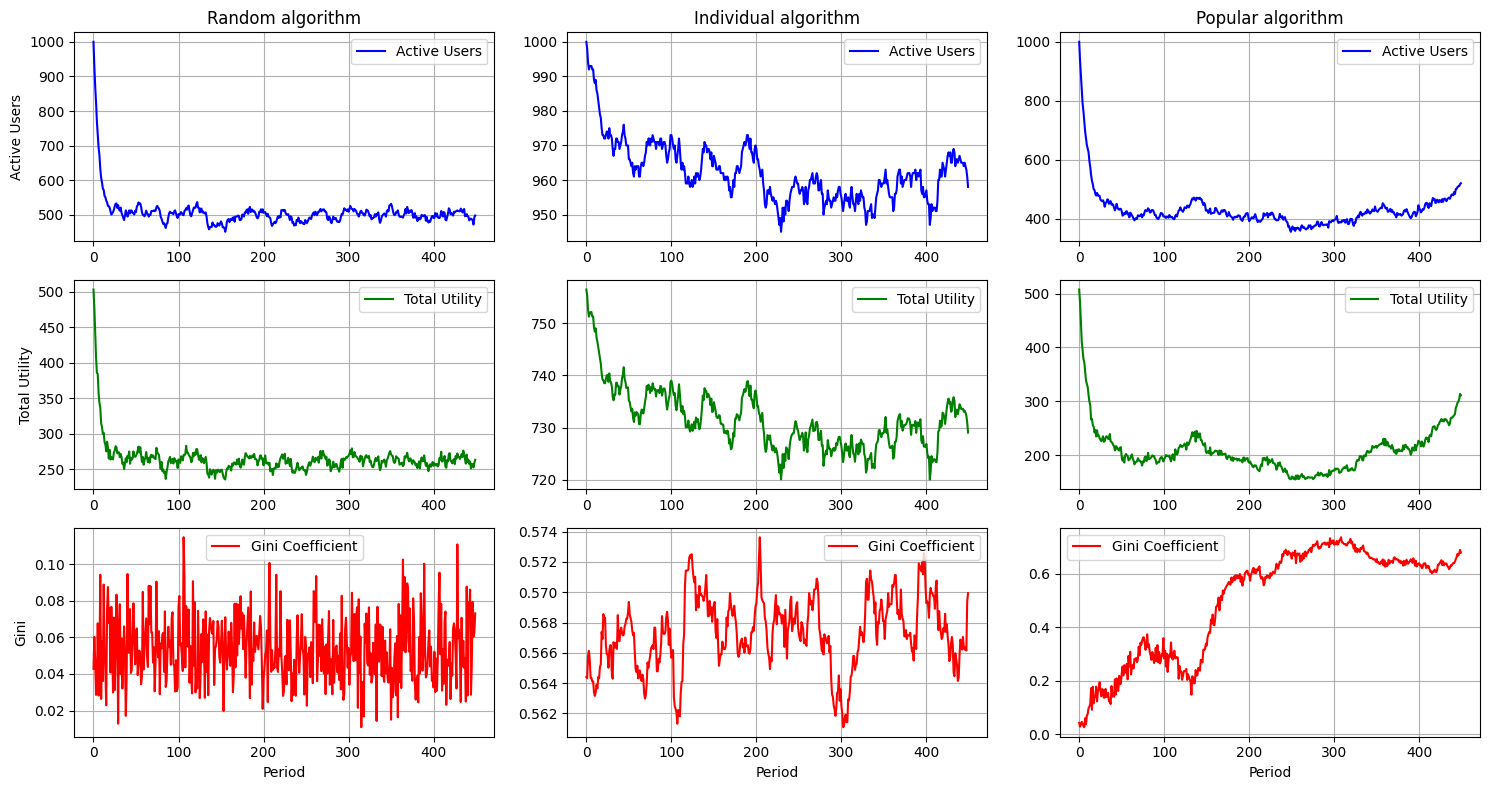

In [3]:
# Heterogenous

N = 1_000
K = 5
T = 450
DELTA = 0.05
SHIFT = -0.1

# Create heterogeneous utilities
U, distributions = create_heterogeneous_utilities(N, K)
print("Distribution parameters for each good:")
for i, (alpha, beta) in enumerate(distributions):
    mean = alpha / (alpha + beta)
    print(f"Good {i}: Beta({alpha:.1f}, {beta:.1f}), Mean = {mean:.3f}")

# Plot the distributions to visualize them
D = np.random.uniform(size=(N, K))
V = U * D
plotSetUp()

# Run simulations for each algorithm type and store the results
algo_types = ['Random', 'Individual', 'Popular']
sim_results = [simulation(algo) for algo in algo_types]

# Create a figure with 3 rows (metrics) and 3 columns (algorithms)
fig, axs = plt.subplots(3, 3, figsize=(15, 8))

# For each algorithm, plot the three metrics
for col, (algo, sim) in enumerate(zip(algo_types, sim_results)):
    periods = np.arange(len(sim['user_history']))
    
    # Row 0: Active Users Over Time
    axs[0, col].plot(periods, sim['user_history'], color='blue', label='Active Users')
    axs[0, col].set_title(f"{algo} algorithm")
    # Set y-axis label only for column 0
    if col == 0:
        axs[0, col].set_ylabel("Active Users")
    else:
        axs[0, col].set_ylabel("")
    # Omit x-axis labels for rows not in the last row
    axs[0, col].set_xlabel("")
    axs[0, col].grid(True)
    axs[0, col].legend()
    
    # Row 1: Cumulative Utility (Welfare) Over Time
    axs[1, col].plot(periods, sim['utility_history'], color='green', label='Total Utility')
    if col == 0:
        axs[1, col].set_ylabel("Total Utility")
    else:
        axs[1, col].set_ylabel("")
    axs[1, col].set_xlabel("")
    axs[1, col].grid(True)
    axs[1, col].legend()
    
    # Row 2: Gini Coefficient Over Time
    axs[2, col].plot(periods, sim['gini_history'], color='red', label='Gini Coefficient')
    if col == 0:
        axs[2, col].set_ylabel("Gini")
    else:
        axs[2, col].set_ylabel("")
    # Set x-axis label only for row 2 (last row)
    axs[2, col].set_xlabel("Period")
    axs[2, col].grid(True)
    axs[2, col].legend()

plt.tight_layout()
plt.show()

# Findings
## Baseline
1. Individual optimization is the best performer with low gini and high social welfare 
2. Popular optimization is poorest performer with high gini and medium social welfare 
3. Randomization and Popular models basically similar welfare performance but GIni is higher for ranomdized
4. Lower quality content (low mean U) simply gives less utility and more differentiation between algos. Popoularity algo is better than randomized algo.
## Heterogenous Goods - 
1. Findings are similar.
2. Individual recommendations are far performant (0.7+ median utility). But much higher Gini than before (because bad content isn't rewarded)
3. Popoularity drives slightly more Social Welfare but with a much higher Gini (10% welfare gains for massive spike in inequality).